In [3]:
# Import packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
!pip install -q timm
from transformers import pipeline
!pip install easyocr
from easyocr import Reader
import requests
import json
!pip install bs4
from bs4 import BeautifulSoup
!pip install tensorflow
from tensorflow.keras.models import load_model
from collections import defaultdict
import os

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 MB 7.0 MB/s eta 0:00:00:00:0100:01
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Scrape game info on BasketballReference

In [132]:
joes = []
errors = []

In [208]:
url = 'https://www.basketball-reference.com/boxscores/201606190GSW.html'
page = requests.get(url)
soup = BeautifulSoup(page.content)
tables = [x for x in soup.find_all('table') if x.get('id') in ['box-CLE-game-basic', 'box-GSW-game-basic']]


players_gsw = ['curryst01', 'thompkl01', 'greendr01', 'iguodan01', 'barneha02']
players_cle = ['jamesle01', 'irvinky01', 'loveke01', 'smithjr01', 'thomptr01']

def mp_str_to_float(x) :
  minutes, seconds = map(int, x.split(':'))
  return minutes + seconds / 60

dfs = []
for table in tables :

  tm = table.get('id').split('-')[1]
  df = pd.read_html(str(table))[0][:-1].drop(5)
  df.columns = df.columns.droplevel(0)
  df['href'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True)]
  df['FG'] = pd.to_numeric(df['FG'], errors = 'coerce')
  df = df[df['FG'].notna()]
  df['MP'] = df['MP'].apply(mp_str_to_float)
  df = df[['Starters', 'href', 'MP']].rename(columns = {'Starters': 'Player'})
  df['Tm'] = tm
  dfs.append(df)

players = pd.concat(dfs).sort_values('MP').reset_index(drop = True)

dfs = []
for tm in ['GSW', 'CLE'] :
  url = f'https://www.basketball-reference.com/teams/{tm}/2016.html'
  page = requests.get(url)
  soup = BeautifulSoup(page.content)
  table = soup.find('table')
  df = pd.read_html(str(table))[0]
  df['href'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'player' in x['href']]
  dfs.append(df[['No.', 'href']])
players = players.merge(pd.concat(dfs), how = 'left', on = 'href')
players = players[players['href'].isin(players_gsw + players_cle)].reset_index(drop = True)

/var/folders/f2/ngwlsnf529q1cz3wyhwh_kf80000gp/T/ipykernel_46638/748216678.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0][:-1].drop(5)
/var/folders/f2/ngwlsnf529q1cz3wyhwh_kf80000gp/T/ipykernel_46638/748216678.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0][:-1].drop(5)
/var/folders/f2/ngwlsnf529q1cz3wyhwh_kf80000gp/T/ipykernel_46638/748216678.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/f2/ngwlsnf529q1cz3wyhwh_kf80000gp/T/ipykernel_46638/748216678.py:36: FutureWarning: Passing literal htm

In [209]:
# Create dictionary maps to player IDs
number_map = {'CLE': dict(zip(players[players['Tm'] == 'CLE']['No.'], players[players['Tm'] == 'CLE']['href'])),
              'GSW': dict(zip(players[players['Tm'] == 'GSW']['No.'], players[players['Tm'] == 'GSW']['href']))}

tm_map = dict(zip(players['href'], players['Tm']))

player_name_map = dict(zip(players['href'], players['Player'].apply(lambda x: x.split(' ')[-1])))

In [210]:
player_name_map

{'barneha02': 'Barnes',
 'loveke01': 'Love',
 'thomptr01': 'Thompson',
 'iguodan01': 'Iguodala',
 'smithjr01': 'Smith',
 'curryst01': 'Curry',
 'thompkl01': 'Thompson',
 'irvinky01': 'Irving',
 'jamesle01': 'James',
 'greendr01': 'Green'}

# Project pipeline

## Load models

In [91]:
# Load models
detection_model  =  pipeline('object-detection', threshold = 0.85, max_objects = 12)
number_model     =  Reader(['en'])
person_model     =  load_model('model_person.h5')
team_model       =  load_model('model_tm.h5')
GSW_model        =  load_model('model_gsw.h5')
CLE_model        =  load_model('model_cle.h5')


# Load CNN class indices
with open('model_person.json', 'r') as f:
    indices_person = json.load(f)
with open('model_tm.json', 'r') as f:
    indices_tm = json.load(f)
with open('model_gsw.json', 'r') as f:
    indices_gsw = json.load(f)
with open('model_cle.json', 'r') as f:
    indices_cle = json.load(f)


indices_map = {'GSW': indices_gsw,
               'CLE': indices_cle}

tm_model_map = {'GSW': GSW_model,
                'CLE': CLE_model}

No model was supplied, defaulted to facebook/detr-resnet-50 and revision 2729413 (https://huggingface.co/facebook/detr-resnet-50).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a 

## Pipeline functions

In [211]:
# Predictive models functions

def object_detection(frame, model) :

      # Convert frame to PIL Image
      image = Image.fromarray(frame)

      # Run the image through the object detection
      results = model(image)

      # Create list of detected persons boxes
      boxes = [res['box'] for res in results if res['label'] == 'person']

      return boxes


def person_classification(image, model, indices) :

  # Predict class of detected person
  pred = model.predict(np.expand_dims(image, axis = 0), verbose = 0).argmax()
  class_ = indices.get(str(pred))

  return class_ == 'player'

def team_classification(image, model, indices) :

  # Predict team of player
  pred = model.predict(np.expand_dims(image, axis = 0), verbose = 0).argmax()
  class_ = indices.get(str(pred))

  return class_


def player_classification(image, tm, model_img, indices, model_txt, thres = 0.9999) :

  found = False
  # Read text on image
  results = model_txt.readtext(image, text_threshold = 0.1, allowlist = '0123456789')

  if len(results) > 0 :
    if len(results[0][1]) > 0 :
        pred_num = int(results[0][1])
        if pred_num in number_map[tm].keys() :
          found = True
          player_id = number_map[tm][pred_num]
          print(f'Classification made on number ({player_id})')

  if not found :

    # Predict player ID
    pred = model_img.predict(np.expand_dims(image, axis = 0), verbose = 0)
    if pred.max() >= thres :
      pred_idx = pred.argmax()
      player_id = indices.get(str(pred_idx))
    else :
      player_id = np.nan

  return player_id

In [212]:
# Projection functions

def apply_homography(H, pts):

    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)

    tpts = np.zeros(pts.shape)
    for i in range(pts.shape[1]):
        u = H[0][0]*pts[0][i] + H[0][1]*pts[1][i] + H[0][2]
        v = H[1][0]*pts[0][i] + H[1][1]*pts[1][i] + H[1][2]
        w = H[2][0]*pts[0][i] + H[2][1]*pts[1][i] + H[2][2]

        x_prime = u/w
        y_prime = v/w

        tpts[0][i] = x_prime
        tpts[1][i] = y_prime

    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])

    return tpts

def project(box, side):

    assert((side == "right") or (side == "left"))

    if side == "right":
        src = np.array([
        [895,280],
        [1280,522], 
        [1,633], 
        [1,325] 
        ]) 

        court = np.array([
        [575, 35],
        [575, 347],
        [306, 347],
        [306, 35],
        ])


    else:

        src = np.array([
        [1260, 338],
        [1250, 660],
        [90, 540],
        [432, 305]
        ])

        court = np.array([
        [306, 35],
        [306, 347],
        [36, 347],
        [36, 35],
        ])

    homography, _ = cv2.findHomography(src, court)
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    xc = x1 + int((x2 - x1)/2)

    player_pos = np.array([[xc],[y2]])
    projected_pos = apply_homography(homography,player_pos)


    return np.array([projected_pos[0][0], projected_pos[1][0]])

In [178]:
def extract_frames(video_path, save_dir):
    # Ouvrir la vidéo
    video_capture = cv2.VideoCapture(video_path)
    frames = []
    k = 0
    # Lire chaque frame de la vidéo
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        # Convertir BGR en RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Ajouter la frame à la liste
        frames.append(frame_rgb)
        
        # Enregistrer la frame dans un fichier image
        frame_filename = os.path.join(save_dir, f"frame_{k}.jpg")
        cv2.imwrite(frame_filename, cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB))
        
        k += 1
    
    # Libérer la ressource de la vidéo
    video_capture.release()
    return frames

# Exemple d'utilisation
video_path = "test_6.mp4"
save_dir = os.path.join(os.getcwd(), "Frames")
frames_list = extract_frames(video_path, save_dir)

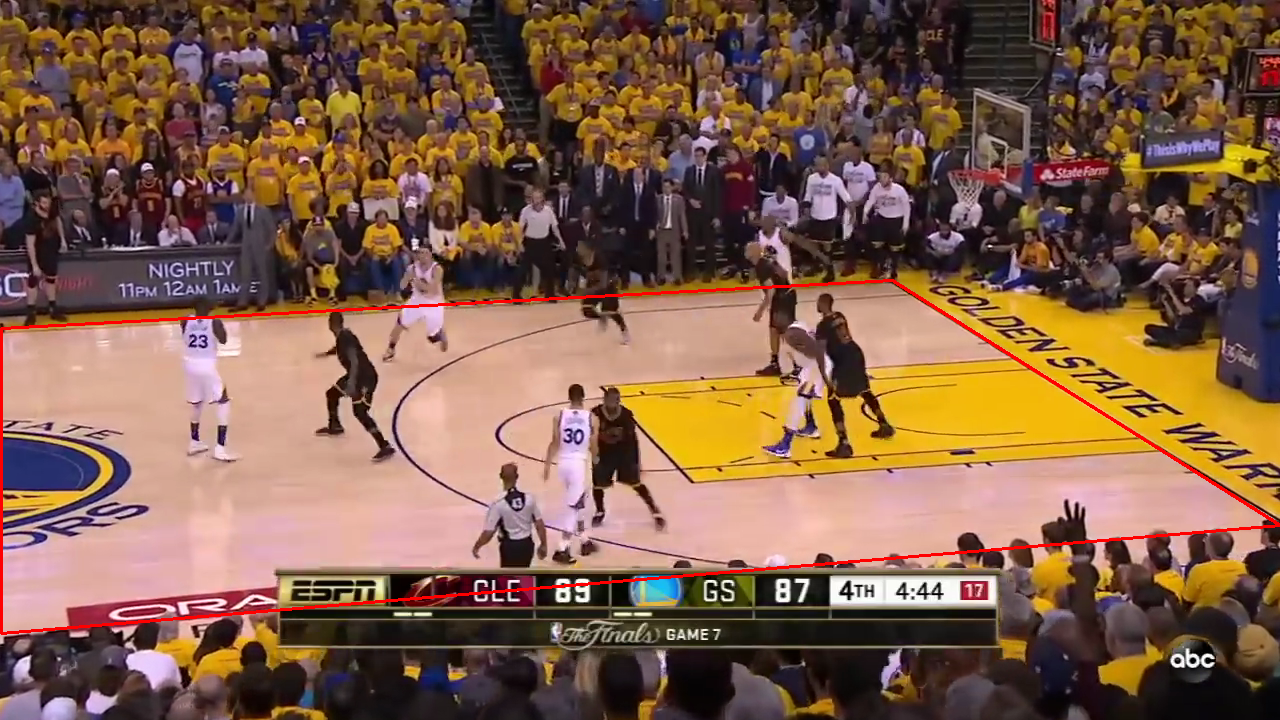

In [179]:
im_l = frames_list[0]
src = np.array([
        [892,280],
        [1280,525],
        [1,633],
        [1,328]
        ])

im_poly = im_l.copy()

cv2.polylines(im_poly, [src], isClosed=True, color=[255,0,0], thickness=2)

Image.fromarray(im_poly)

In [213]:
# Trajectory interpolation functions

def interpolate_points(players_trajectories: dict):

    """
    Modify the player trajectories dict by interpolating the points that are missing
    """

    for player, traj in players_trajectories.items():
        ind_nan = np.isnan(np.array(traj["x"]))
        ind_non_nan = ~ind_nan
        x_interp = np.array(traj["x"]).copy()
        y_interp = np.array(traj["y"]).copy()
        x_interp[ind_nan] = np.interp(np.flatnonzero(ind_nan), np.flatnonzero(ind_non_nan), np.array(traj["x"])[ind_non_nan])
        y_interp[ind_nan] = np.interp(np.flatnonzero(ind_nan), np.flatnonzero(ind_non_nan), np.array(traj["y"])[ind_non_nan])
        players_trajectories[player]["x"] = x_interp
        players_trajectories[player]["y"] = y_interp

    return players_trajectories

def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def closest_distance(x_player: float, y_player: float, coords: list):
    """
    Get the closest defender distance for a given player

    x_player: x position of the player
    y_player: y position of the player
    coords: coordinates of all defense players, list of tuples of size 2
    """
    minimum = np.inf
    for x, y in coords:
        if distance(x_player, y_player, x, y) < minimum:
            minimum = distance(x_player, y_player, x, y)

    return minimum

def discard_errors(players_trajectories: dict, first_positions: dict, tresh: float):

    """
    Remove any wrong predictions by a given treshold
    """
    new_trajectories = players_trajectories.copy()
    new_trajectories = { key : {"x": [first_positions[key][0]], "y": [first_positions[key][1]]} for key, _ in new_trajectories.items()}
    nb_frames = len(list(players_trajectories.values())[0]["x"])
    for player, traj in players_trajectories.items():
        step_forward = 0
        for t in range(nb_frames-1):
            t = t + step_forward
            if t >= nb_frames-1: # break if we are over the length of the sequence
                break
            close = False
            step = 0
            while not close:
                ## get the tamp list with only nans
                tamp_x, tamp_y = np.full(2 + step, np.nan), np.full(2 + step, np.nan)

                ## fix the first and last point
                if t == 0:
                    tamp_x[0], tamp_y[0], tamp_x[-1], tamp_y[-1] = first_positions[player][0], first_positions[player][1], traj["x"][t + 1+step], traj["y"][t +1+step]
                else:
                    tamp_x[0], tamp_y[0], tamp_x[-1], tamp_y[-1] = traj["x"][t], traj["y"][t], traj["x"][t + 1+step], traj["y"][t +1+step]

                ## interpolate the list
                ind_non_nan = np.arange(len(tamp_x))[~np.isnan(tamp_x)]
                tamp_int_x = np.interp(np.arange(len(tamp_x)), ind_non_nan, tamp_x[ind_non_nan])
                tamp_int_y = np.interp(np.arange(len(tamp_y)), ind_non_nan, tamp_y[ind_non_nan])

                ## test if the next point is close enough
                if (distance(tamp_int_x[0], tamp_int_y[0], tamp_int_x[1], tamp_int_y[1]) <= tresh) and (traj["y"][t+1+step] < 345) and (traj["y"][t+1+step] > 35) :
                    close = True
                    new_trajectories[player]["x"].append(traj["x"][t+1+step])
                    new_trajectories[player]["y"].append(traj["y"][t+1+step])

                ## else we add a np.nan and look at the next point
                else:
                    new_trajectories[player]["x"].append(np.nan)
                    new_trajectories[player]["y"].append(np.nan)
                    step_forward += 1
                    step += 1

                ## break the loop if we are at the end of the sequences
                if t + step >= nb_frames - 1:
                    break
            
        assert(len(new_trajectories[player]["x"]) == nb_frames)

    return new_trajectories


def compute_joe(players_trajectories: dict, players_teams: dict, offense_team: str):
    """
    Compute Joe for every offense players on the sequence

    players_trajectories (dict): trajectories dico
    players_teams (dict): matching dico for players and teams
    offense_team (str): name of the team (as on the players_teams dict)
    """

    nb_frames = len(list(players_trajectories.values())[0]["x"])
    joe = defaultdict(list)

    offense_players = [player for player in players_trajectories.keys() if players_teams[player] == offense_team]
    defense_players = [player for player in players_trajectories.keys() if players_teams[player] != offense_team]

    for t in range(nb_frames):
        def_coords = [(players_trajectories[player]["x"][t], players_trajectories[player]["y"][t]) for player in defense_players]
        for player in offense_players:
            joe[player].append(closest_distance(players_trajectories[player]["x"][t], players_trajectories[player]["y"][t], def_coords))

    return {key: np.mean(value) for key, value in joe.items()}

## Running the pipeline

In [214]:
### Inputs ###
video_path = 'test_2.mp4'
side = 'right'
verbose = True
##############

# Load the sequence video
vidcap = cv2.VideoCapture(video_path)
total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

# Read a frame
ret, frame = vidcap.read()

# Initiate output
output = {key: {'x': np.array(int(total_frames) * [np.nan]).copy(), 'y': np.array(int(total_frames) * [np.nan]).copy()}
          for key in players['href']}

# Loop along the frames of the video
t = 0
ret = True
while ret :

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform object detection on the frame
    persons = object_detection(frame, detection_model)

    # Count number of detections
    num_detections = {x: 0 for x in players_gsw + players_cle}

    # Display progress
    if verbose :
      prog = round(100 * (t + 1) / total_frames, 1)
      print(f'[{prog}%] Detected {len(persons)} persons in frame {t+1}/{int(total_frames)} ...           ')

    # Loop over detected persons
    for person in persons :

        # Crop to object detection box
        xmin, ymin, xmax, ymax = person.values()
        image = frame[ymin:ymax, xmin:xmax]
        # Resize image network input size
        image = np.array(Image.fromarray(image).resize((128, 128)))

        # Classify whether the person is a player
        isPlayer = person_classification(image, person_model, indices_person)

        if isPlayer :

            # Classify player's team
            tm = team_classification(image, team_model, indices_tm)

            # Classify player
            player_id = player_classification(image, tm, tm_model_map[tm], indices_map[tm], number_model)
            if type(player_id) is str :
                num_detections[player_id] += 1

            # Project player's (x, y) coordinates
            x, y = project((xmin, ymin, xmax, ymax), side)

            # Update the trajectories
            try :
              output[player_id]['x'][t] = x
              output[player_id]['y'][t] = y
            except :
              pass

        else :
            pass

    # Override double-predictions
    for player_id, count in num_detections.items() :
      if count > 1 :
        output[player_id]['x'][t] = np.nan
        output[player_id]['y'][t] = np.nan

    # Update timer
    t += 1

    # Read a frame
    ret, frame = vidcap.read()

vidcap.release()

[0.2%] Detected 10 persons in frame 1/417 ...           
[0.5%] Detected 11 persons in frame 2/417 ...           
[0.7%] Detected 10 persons in frame 3/417 ...           
[1.0%] Detected 10 persons in frame 4/417 ...           
[1.2%] Detected 8 persons in frame 5/417 ...           
[1.4%] Detected 8 persons in frame 6/417 ...           
[1.7%] Detected 10 persons in frame 7/417 ...           
[1.9%] Detected 8 persons in frame 8/417 ...           
[2.2%] Detected 8 persons in frame 9/417 ...           
[2.4%] Detected 10 persons in frame 10/417 ...           
[2.6%] Detected 9 persons in frame 11/417 ...           
[2.9%] Detected 10 persons in frame 12/417 ...           
[3.1%] Detected 11 persons in frame 13/417 ...           
[3.4%] Detected 12 persons in frame 14/417 ...           
[3.6%] Detected 10 persons in frame 15/417 ...           
[3.8%] Detected 11 persons in frame 16/417 ...           
[4.1%] Detected 10 persons in frame 17/417 ...           
[4.3%] Detected 10 persons i

## Trajectories cleaning

In [215]:
# Hard code positions in the first frame to help interpolation
first_positions = {"greendr01": (369, 247), "jamesle01" : (392, 248), "irvinky01": (415, 282),
                   "barneha02": (439, 85), "thomptr01": (467, 128), "iguodan01": (538, 93),
                   "thompkl01": (553, 330), 'curryst01': (402, 286), "smithjr01": (553, 328),
                   "loveke01": (540, 125)}

In [236]:
# Uncomment in case the number of frames is more than what it actually is
output_ = {player_id: {'x': list(data['x'][:t]), 'y': list(data['y'][:t])} for player_id, data in output.items()}
output_bis = output_.copy()
#output_ = output.copy()

In [232]:
im = cv2.imread('cout_background.jpeg')

[ WARN:0@73874.992] global loadsave.cpp:248 findDecoder imread_('cout_background.jpeg'): can't open/read file: check file path/integrity


In [238]:
# Interpolate missing values
traj_interpolate = interpolate_points(output_)
# Discard errors
traj_discard = discard_errors(traj_interpolate, first_positions, 2)
# Re-interpolate for errors
final_trajectories = interpolate_points(traj_discard)
final_trajectories = {player_id: {'x': list(data['x'][:t]), 'y': list(data['y'][:t])} for player_id, data in final_trajectories.items()}

In [240]:
with open("pre_traj.json", "w") as fichier:
    fichier.write(json.dumps(output_bis))

with open("post_traj.json", "w") as fichier:
    fichier.write(json.dumps(final_trajectories))

## Results

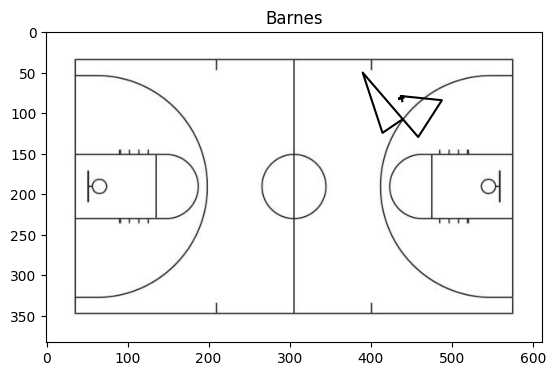

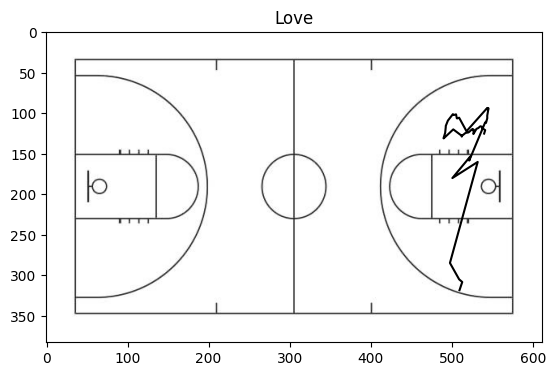

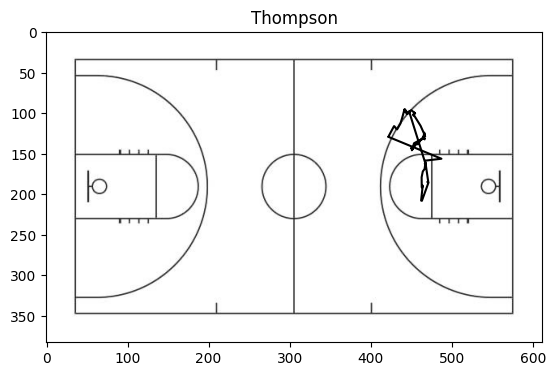

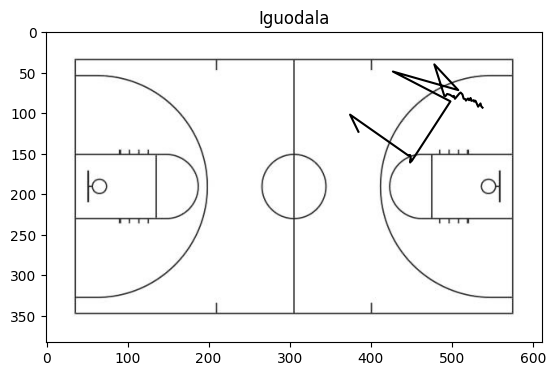

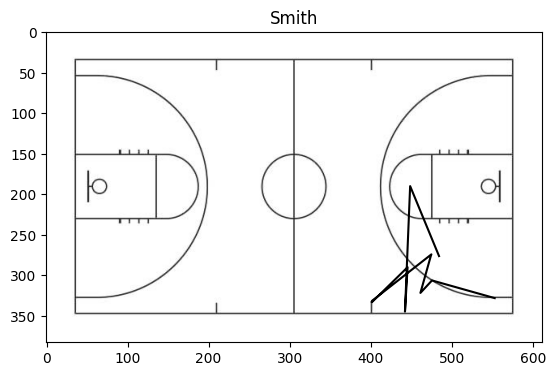

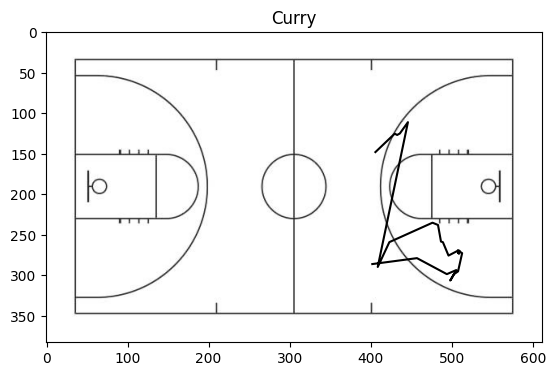

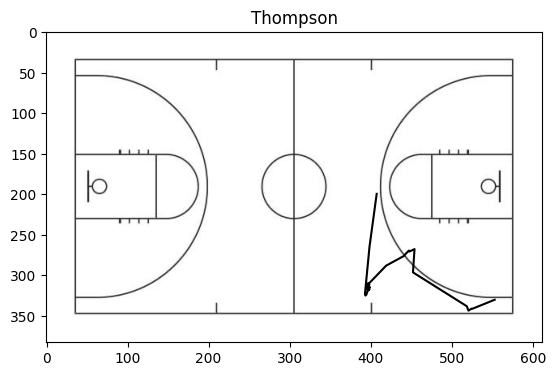

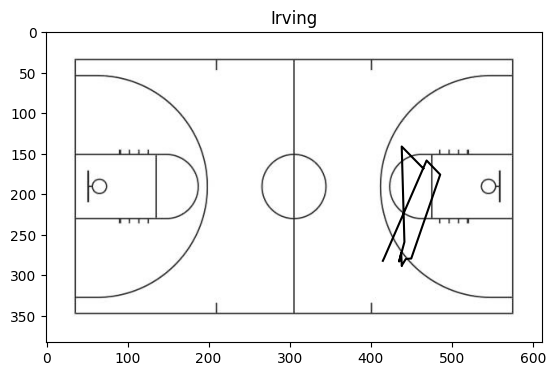

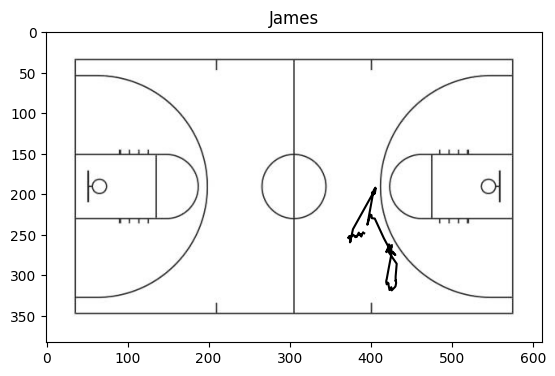

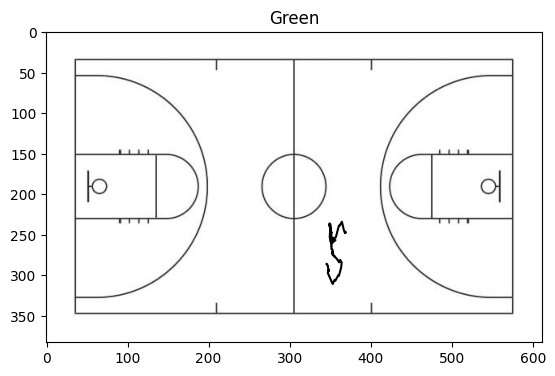

In [241]:
# Plot results
im = cv2.imread('court_background.jpeg')
for player, traj in final_trajectories.items() :
  plt.figure()
  plt.imshow(im)
  plt.title(player_name_map.get(player))
  plt.plot(traj['x'], traj['y'], 'k-')
  plt.show()

In [160]:
# Compute attraction metric
joe = compute_joe(final_trajectories, tm_map, 'GSW')
#joes.append(joe)
joe

{'barneha02': 124.38071070006393,
 'iguodan01': 57.26764387540561,
 'curryst01': 37.468315809456435,
 'thompkl01': 93.92464699381928,
 'greendr01': 60.25170496797949}

In [129]:
def get_true_pos(x, y):
    ratio = 0.158
    x0, y0 = 575, 35
    return (x0 - y/ratio, y0 + x/ratio)

get_true_pos(20.8, 17.9)


(461.7088607594937, 166.64556962025316)

In [187]:
# Evaluation
shooter = 'thompkl01'
true_pos = get_true_pos(22, 3.8)
traj_shooter = final_trajectories[shooter]
pred_pos = (traj_shooter['x'][-1], traj_shooter['y'][-1]) # assuming the shot is the last frame of the video

# Compute error in feet
error = 0.158 * distance(true_pos[0], true_pos[1], pred_pos[0], pred_pos[1])
#errors.append(error)
print(error)

20.85077470846061


In [245]:
# Evaluation
true_pos = get_true_pos(35.4, 36.8)
pred_pos = (450, 180) # assuming the shot is the last frame of the video

# Compute error in feet
error = 0.158 * distance(true_pos[0], true_pos[1], pred_pos[0], pred_pos[1])
#errors.append(error)
print(error)

21.135340072967836


In [246]:
a = [15.26, 2.8, 15.98, 21.13]
np.std(a)

6.738187348983404

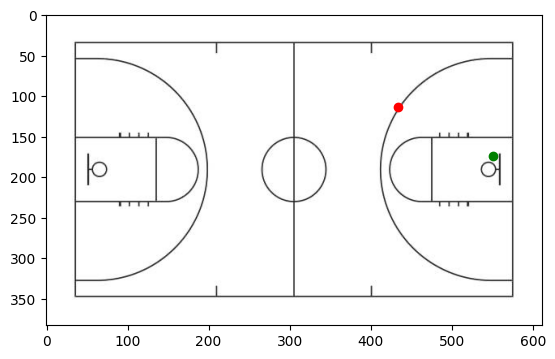

In [200]:
plt.imshow(im)
plt.scatter(pred_pos[0], pred_pos[1], c = 'r')
plt.scatter(true_pos[0], true_pos[1], c = 'g')
plt.show()

In [ ]:
# Plot trajectories of both teams
k = 50
for i in range(len(list(final_trajectories.values())[0]["x"])) :

    _, ax = plt.subplots(2, 1, figsize = (8, 12))
    ax[0].imshow(im, alpha = 0.7)
    ax[1].imshow(im, alpha = 0.7)
    ax[0].set_xlim([300, 600]); ax[0].axis('off')
    ax[1].set_xlim([300, 600]); ax[1].axis('off')
    for player, traj in final_trajectories.items() :
      if player in players_gsw :
        ax[0].scatter(traj['x'][i], traj['y'][i], s = 100, c = '#1D428A')
        ax[0].text(traj['x'][i], traj['y'][i], '  ' + player_name_map.get(player), ha = 'left')
        if i > 1 :
          ax[0].scatter(traj['x'][np.maximum(0, i-k):i], traj['y'][np.maximum(0, i-k):i], c = np.linspace(0, np.minimum(i, k), np.minimum(i, k)), cmap = 'Blues', alpha = 0.5)
      elif player in players_cle :
        ax[1].scatter(traj['x'][i], traj['y'][i], s = 100, c = '#860038')
        ax[1].text(traj['x'][i], traj['y'][i], '  ' + player_name_map.get(player), ha = 'left')
        if i > 1 :
          ax[1].scatter(traj['x'][np.maximum(0, i-k):i], traj['y'][np.maximum(0, i-k):i], c = np.linspace(0, np.minimum(i, k), np.minimum(i, k)), cmap = 'Reds', alpha = 0.5)

    plt.tight_layout()
    plt.savefig(f'frames/frame_{str(i).zfill(4)}.png', dpi = 200)
    plt.close()

In [ ]:
# Plot trajectories of Golden State Warriors
k = 50
for i in range(len(list(final_trajectories.values())[0]["x"])) :

    _, ax = plt.subplots(1, 1, figsize = (12, 12))
    ax.imshow(im, alpha = 0.7)
    ax.set_xlim([300, 600]); ax.axis('off')
    for player, traj in final_trajectories.items() :
      if player in players_gsw :
        ax.scatter(traj['x'][i], traj['y'][i], s = 250, c = '#1D428A')
        ax.text(traj['x'][i], traj['y'][i], '  ' + player_name_map.get(player), ha = 'left', size = 24)
        if i > 1 :
          ax.scatter(traj['x'][np.maximum(0, i-k):i], traj['y'][np.maximum(0, i-k):i], c = np.linspace(0, np.minimum(i, k), np.minimum(i, k)), cmap = 'Blues', alpha = 0.5)

    plt.tight_layout()
    plt.savefig(f'frames_gsw/frame_{str(i).zfill(4)}.png', dpi = 200)
    plt.close()

In [ ]:
def create_movie(image_folder, output_path, fps = 24) :

    # Get the list of image files
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder)])

    # Read the first image to get dimensions
    first_image = cv2.imread(image_files[0])
    height, width, _ = first_image.shape

    # Initialize VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write images to video
    for image_file in image_files:
        frame = cv2.imread(image_file)
        video_writer.write(frame)

    # Release video object
    video_writer.release()

#create_movie('frames_gsw', 'traj_gsw.mp4', fps = 30)

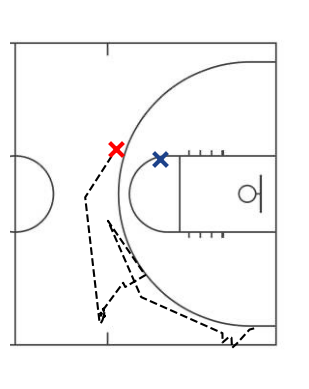

In [ ]:
plt.imshow(im, alpha = 0.9)
plt.plot(traj_shooter['x'], traj_shooter['y'], c = 'k', linestyle = '--')
plt.scatter(pred_pos[0], pred_pos[1], c = 'r', marker = 'x', zorder = 10, s = 100, linewidth = 3)
plt.scatter(true_pos[0], true_pos[1], c = '#1D428A', marker = 'x', zorder = 10, s = 100, linewidth = 3)

plt.xlim([300, 600]); plt.axis('off')

plt.savefig('traj_klay.png', dpi = 250)
plt.show()

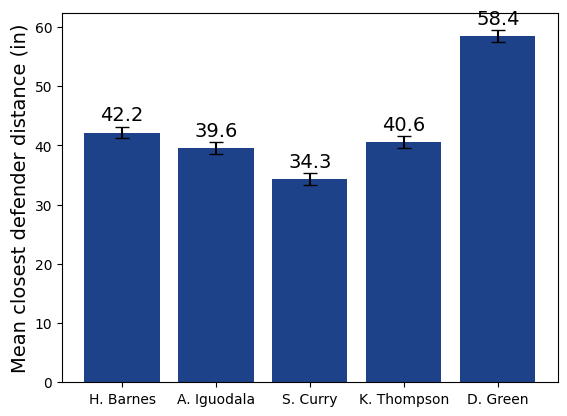

In [ ]:
plt.bar(['H. Barnes', 'A. Iguodala', 'S. Curry', 'K. Thompson', 'D. Green'], joe.values(), yerr = 1, capsize = 5, color = '#1D428A', ecolor = 'k', linewidth = 3)
plt.ylabel('Mean closest defender distance (in)', fontsize = 14)
for i, val in enumerate(joe.values()) :
    plt.text(i, val + 2, str(round(val, 1)), ha = 'center', size = 14)
plt.show()

In [106]:
joe1

{'barneha02': 43.85616049713172,
 'iguodan01': 60.92450620450545,
 'curryst01': 49.30324148874056,
 'thompkl01': 52.428109469374235,
 'greendr01': 26.601503561444982}

In [164]:
def average_joe(liste):
    n = len(liste)
    res = {}
    for player, _ in liste[0].items():
        tamp = []
        for k in range(n):
            tamp.append(liste[k][player])
        res[player] = np.mean(tamp)

    return res




In [165]:
average_joe(joes)

{'barneha02': 84.0035371899385,
 'iguodan01': 59.03994150308637,
 'curryst01': 46.45765630357474,
 'thompkl01': 73.17417763112722,
 'greendr01': 43.42660426471224}

In [202]:
errors

[11.510741666276314, 2.21, 7.6, 4.3]

In [242]:
np.std(errors)

3.518723945737745

In [ ]:
12.1